## Prepare Notebook

In [78]:
from datetime import UTC, datetime

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpyro
import polars as pl
import seaborn as sns
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from pydantic import BaseModel
from retention_data import CohortDataGenerator
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    OneHotEncoder,
    StandardScaler,
)
from numpyro.contrib.module import nnx_module
import numpyro.distributions as dist

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Data

In [3]:
class Market(BaseModel):
    """Class to represent a market."""

    name: str
    start_date: datetime
    n_cohorts: int
    user_base: int = 10_000


class MarketDataGenerator:
    """Class to generate market data from the cohort data generator."""

    def __init__(self, markets: list[Market], rng: np.random.Generator):
        self.markets = markets
        self.rng = rng

    def run(self) -> pl.DataFrame:
        data_dfs: list[pl.DataFrame] = []

        for market in self.markets:
            cohort_generator = CohortDataGenerator(
                rng=self.rng, start_cohort=market.start_date, n_cohorts=market.n_cohorts
            )
            data_df = cohort_generator.run()

            # Add some features
            data_df = data_df.with_columns(
                (pl.col("n_active_users") / pl.col("n_users")).alias("retention"),
                pl.lit(market.name).alias("market"),
                (pl.col("cohort").dt.month()).alias("cohort_month"),
                (pl.col("period").dt.month()).alias("period_month"),
            )
            data_dfs.append(data_df)
        return pl.concat(data_dfs)


# Set up the markets
markets = [
    Market(
        name="A",
        start_date=datetime(2020, 1, 1, tzinfo=UTC),
        n_cohorts=48,
        user_base=10_000,
    ),
    Market(
        name="B",
        start_date=datetime(2021, 4, 1, tzinfo=UTC),
        n_cohorts=33,
        user_base=4_000,
    ),
    Market(
        name="C",
        start_date=datetime(2022, 1, 1, tzinfo=UTC),
        n_cohorts=24,
        user_base=1_000,
    ),
]

# Generate the data
n_markets = len(markets)
market_data_generator = MarketDataGenerator(markets=markets, rng=rng)
data_df = market_data_generator.run()

data_df.head()

cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users,revenue,retention,market,cohort_month,period_month
date,i64,date,i64,i64,f64,f64,i64,f64,f64,str,i8,i8
2020-01-01,150,2020-01-01,1430,0,-1.807373,0.140956,150,14019.256906,1.0,"""A""",1,1
2020-01-01,150,2020-02-01,1430,31,-1.474736,0.186224,25,1886.501237,0.166667,"""A""",1,2
2020-01-01,150,2020-03-01,1430,60,-2.281286,0.092685,13,1098.136314,0.086667,"""A""",1,3
2020-01-01,150,2020-04-01,1430,91,-3.20661,0.038918,6,477.852458,0.04,"""A""",1,4
2020-01-01,150,2020-05-01,1430,121,-3.112983,0.042575,2,214.667937,0.013333,"""A""",1,5


In [4]:
# Verify the data has the same last period for each market
assert (
    len(
        set(
            data_df.group_by("market")
            .agg(pl.col("period").max().alias("max_period"))["max_period"]
            .to_list()
        )
    )
    == 1
)

## Train-Test Split

In [5]:
period_train_test_split = datetime(2022, 11, 1, tzinfo=UTC)

train_data_df = data_df.filter(pl.col("period") <= pl.lit(period_train_test_split))
test_data_df = data_df.filter(pl.col("period") > pl.lit(period_train_test_split))
test_data_df = test_data_df.filter(
    pl.col("cohort").is_in(train_data_df["cohort"].unique().to_list())
)

## Data Visualization

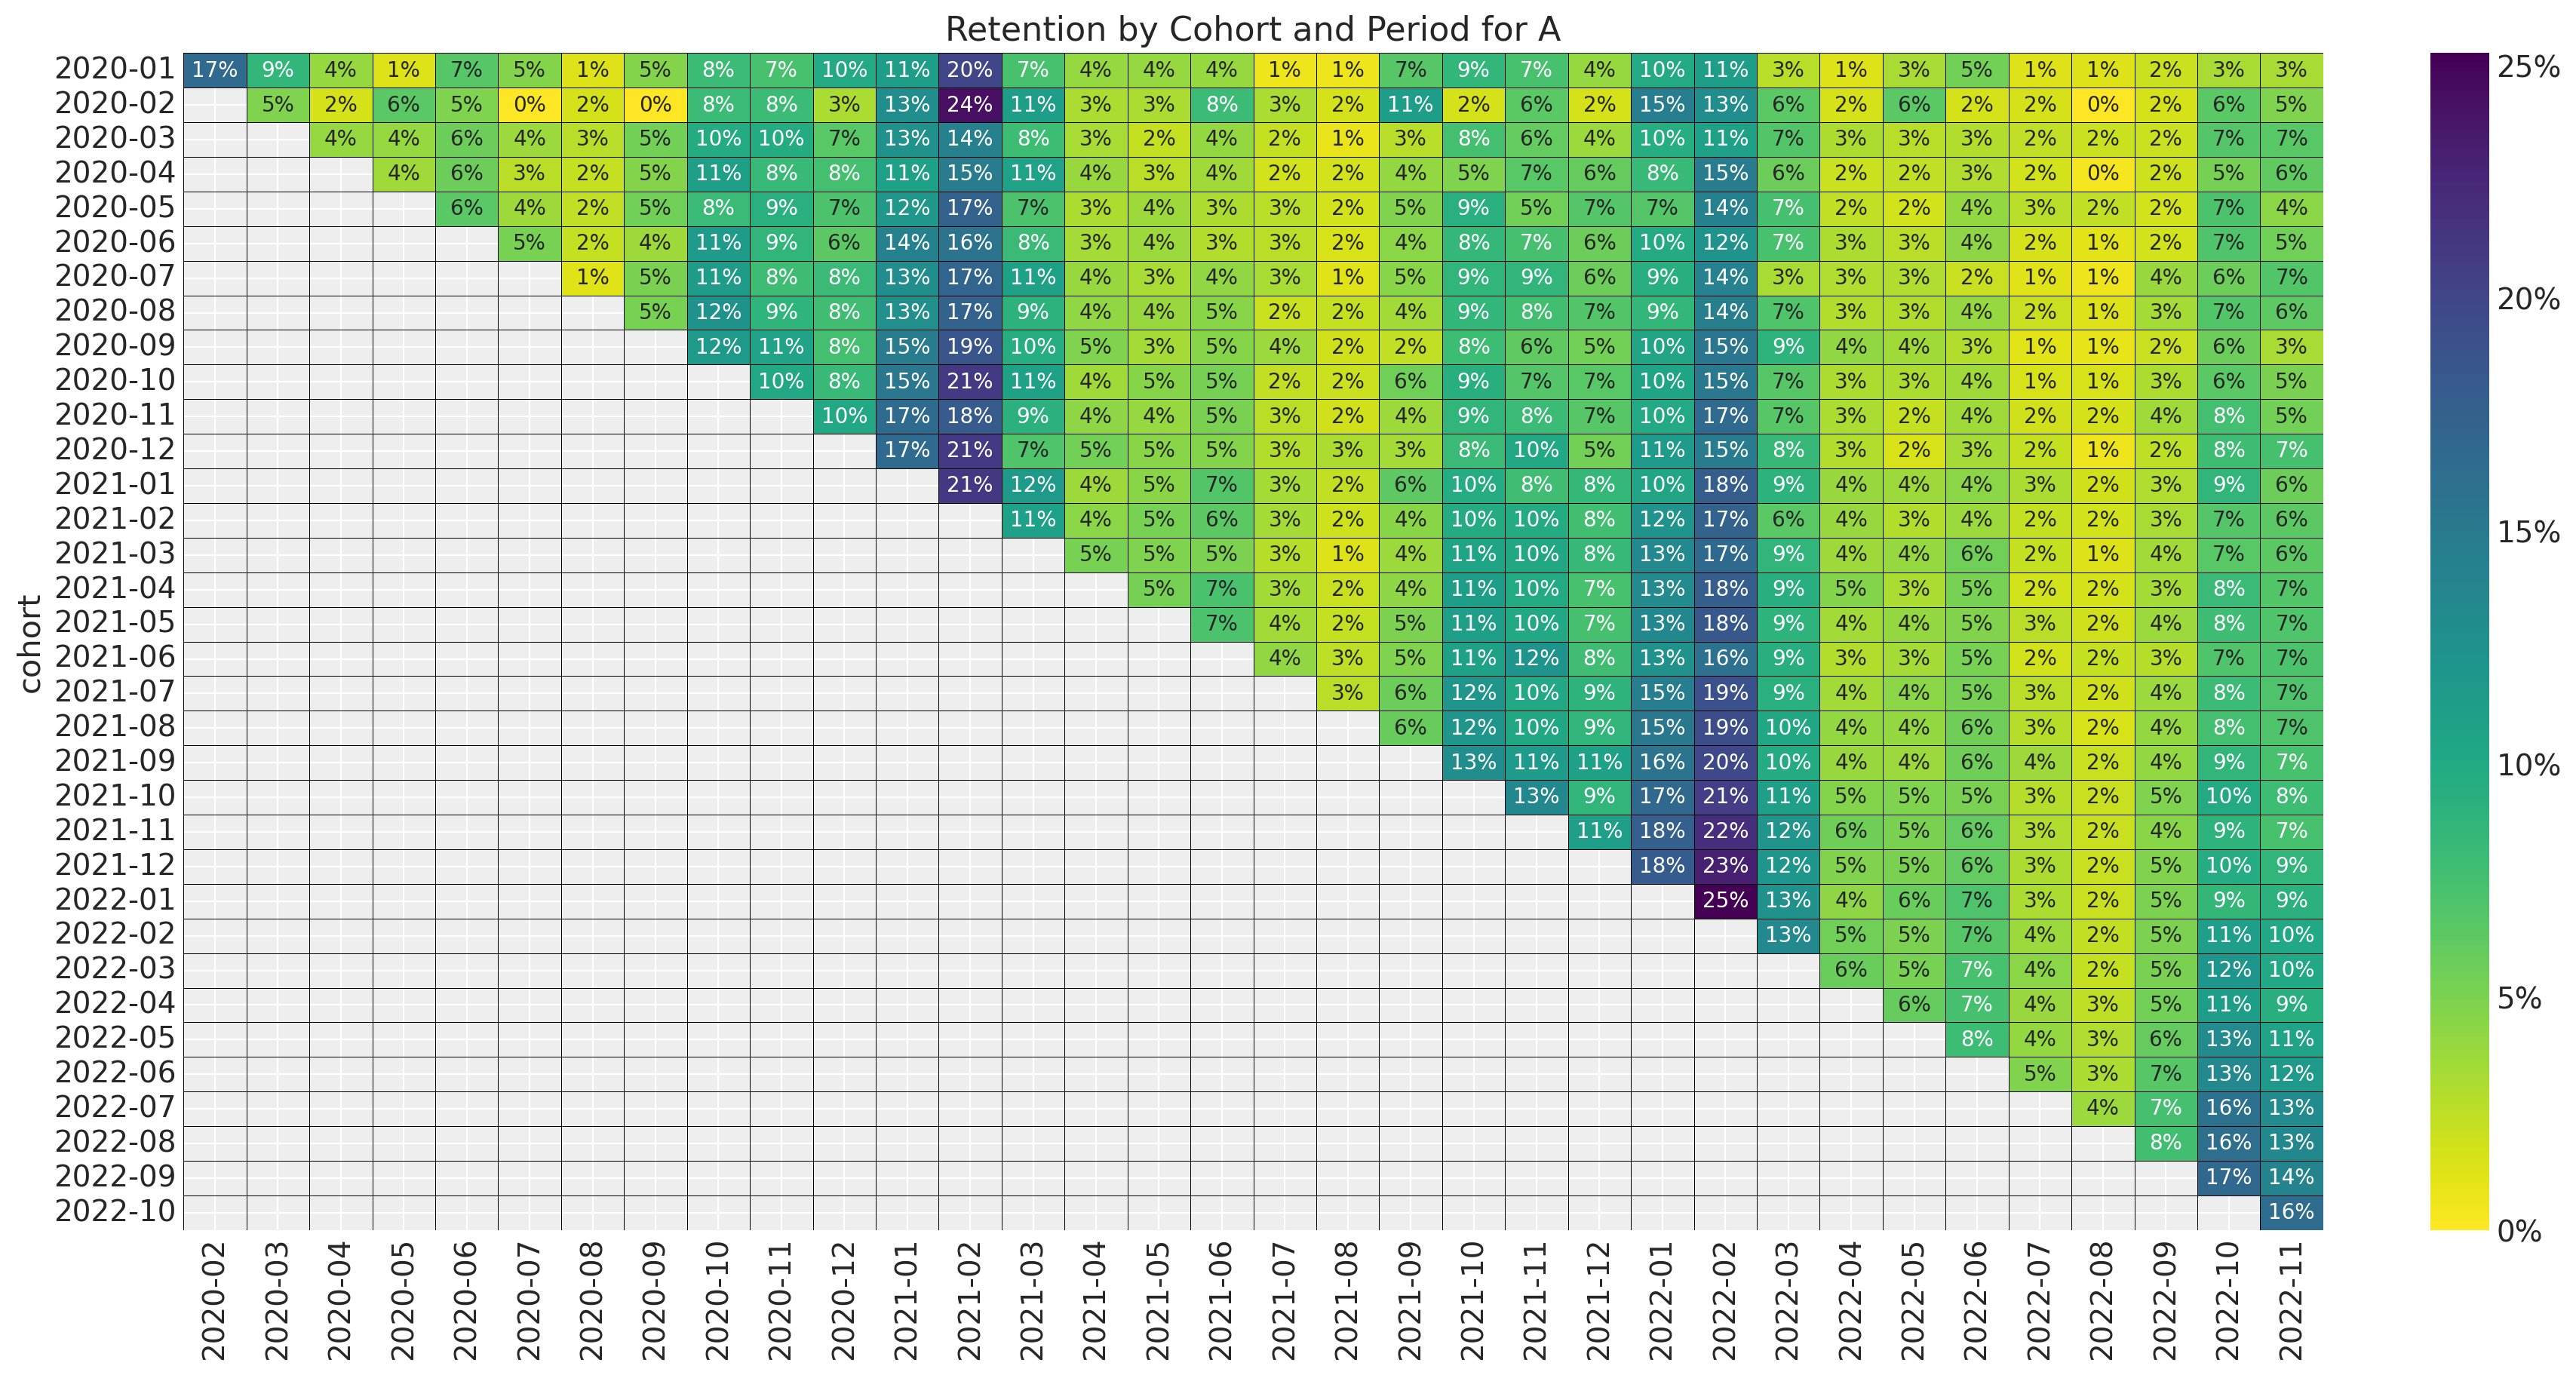

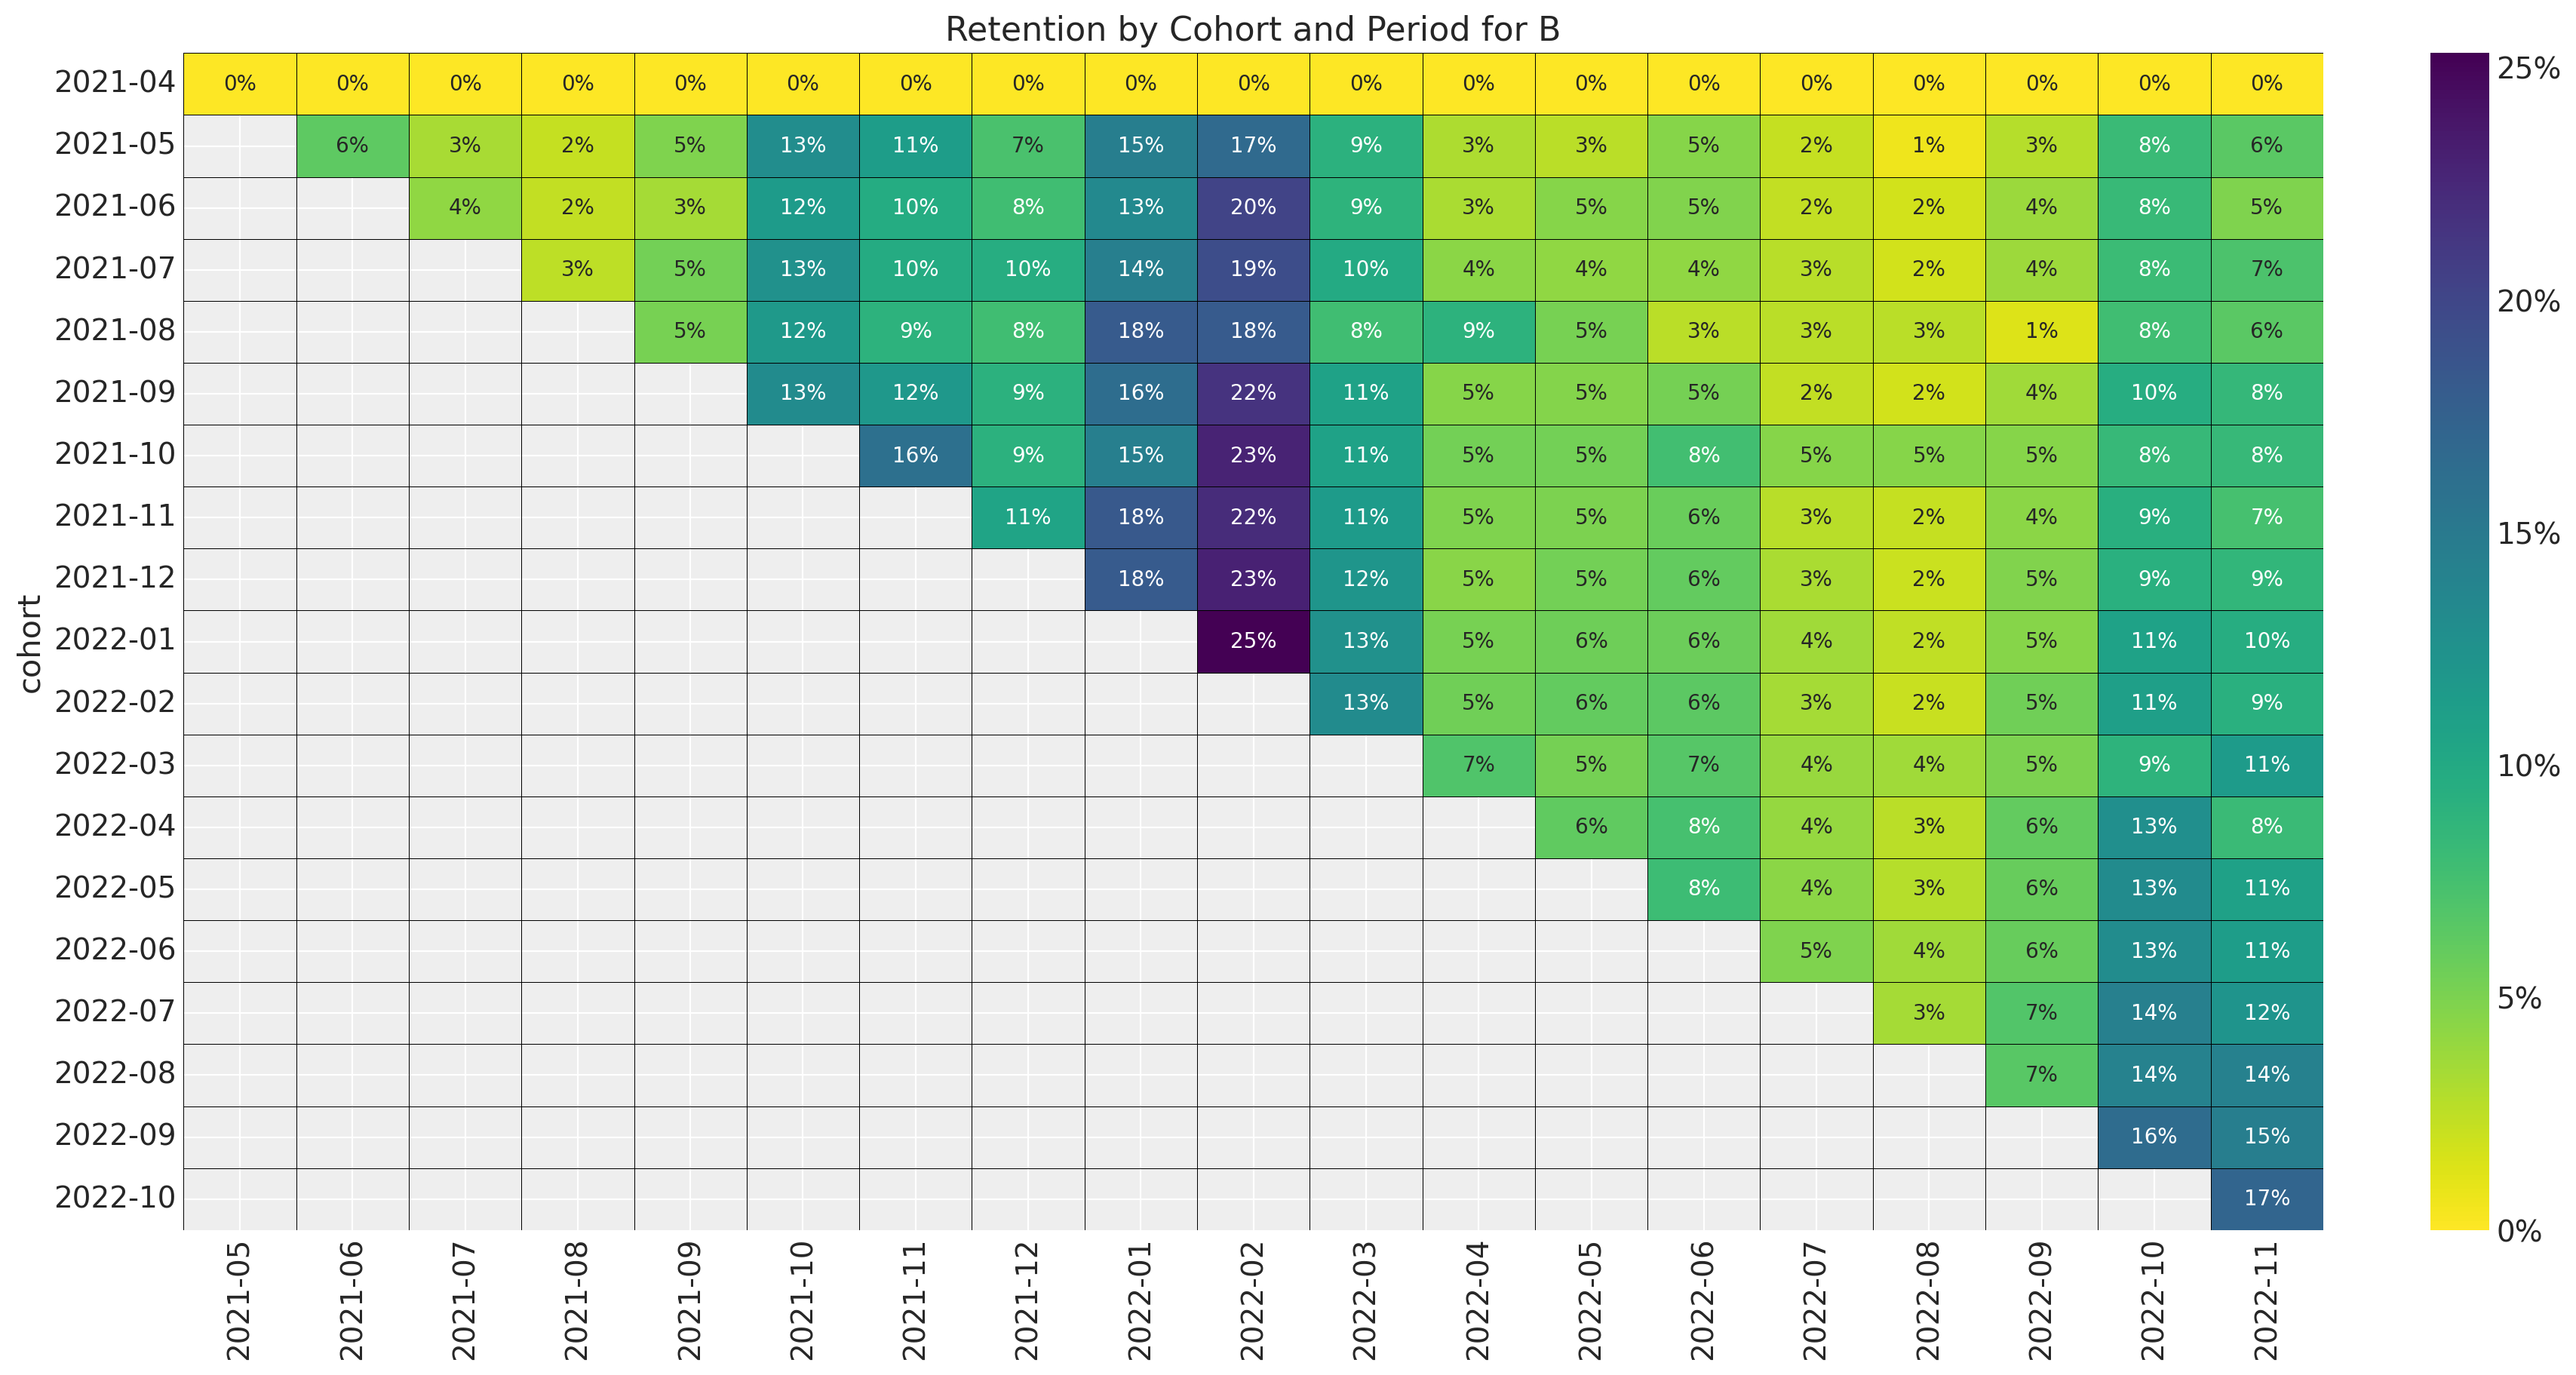

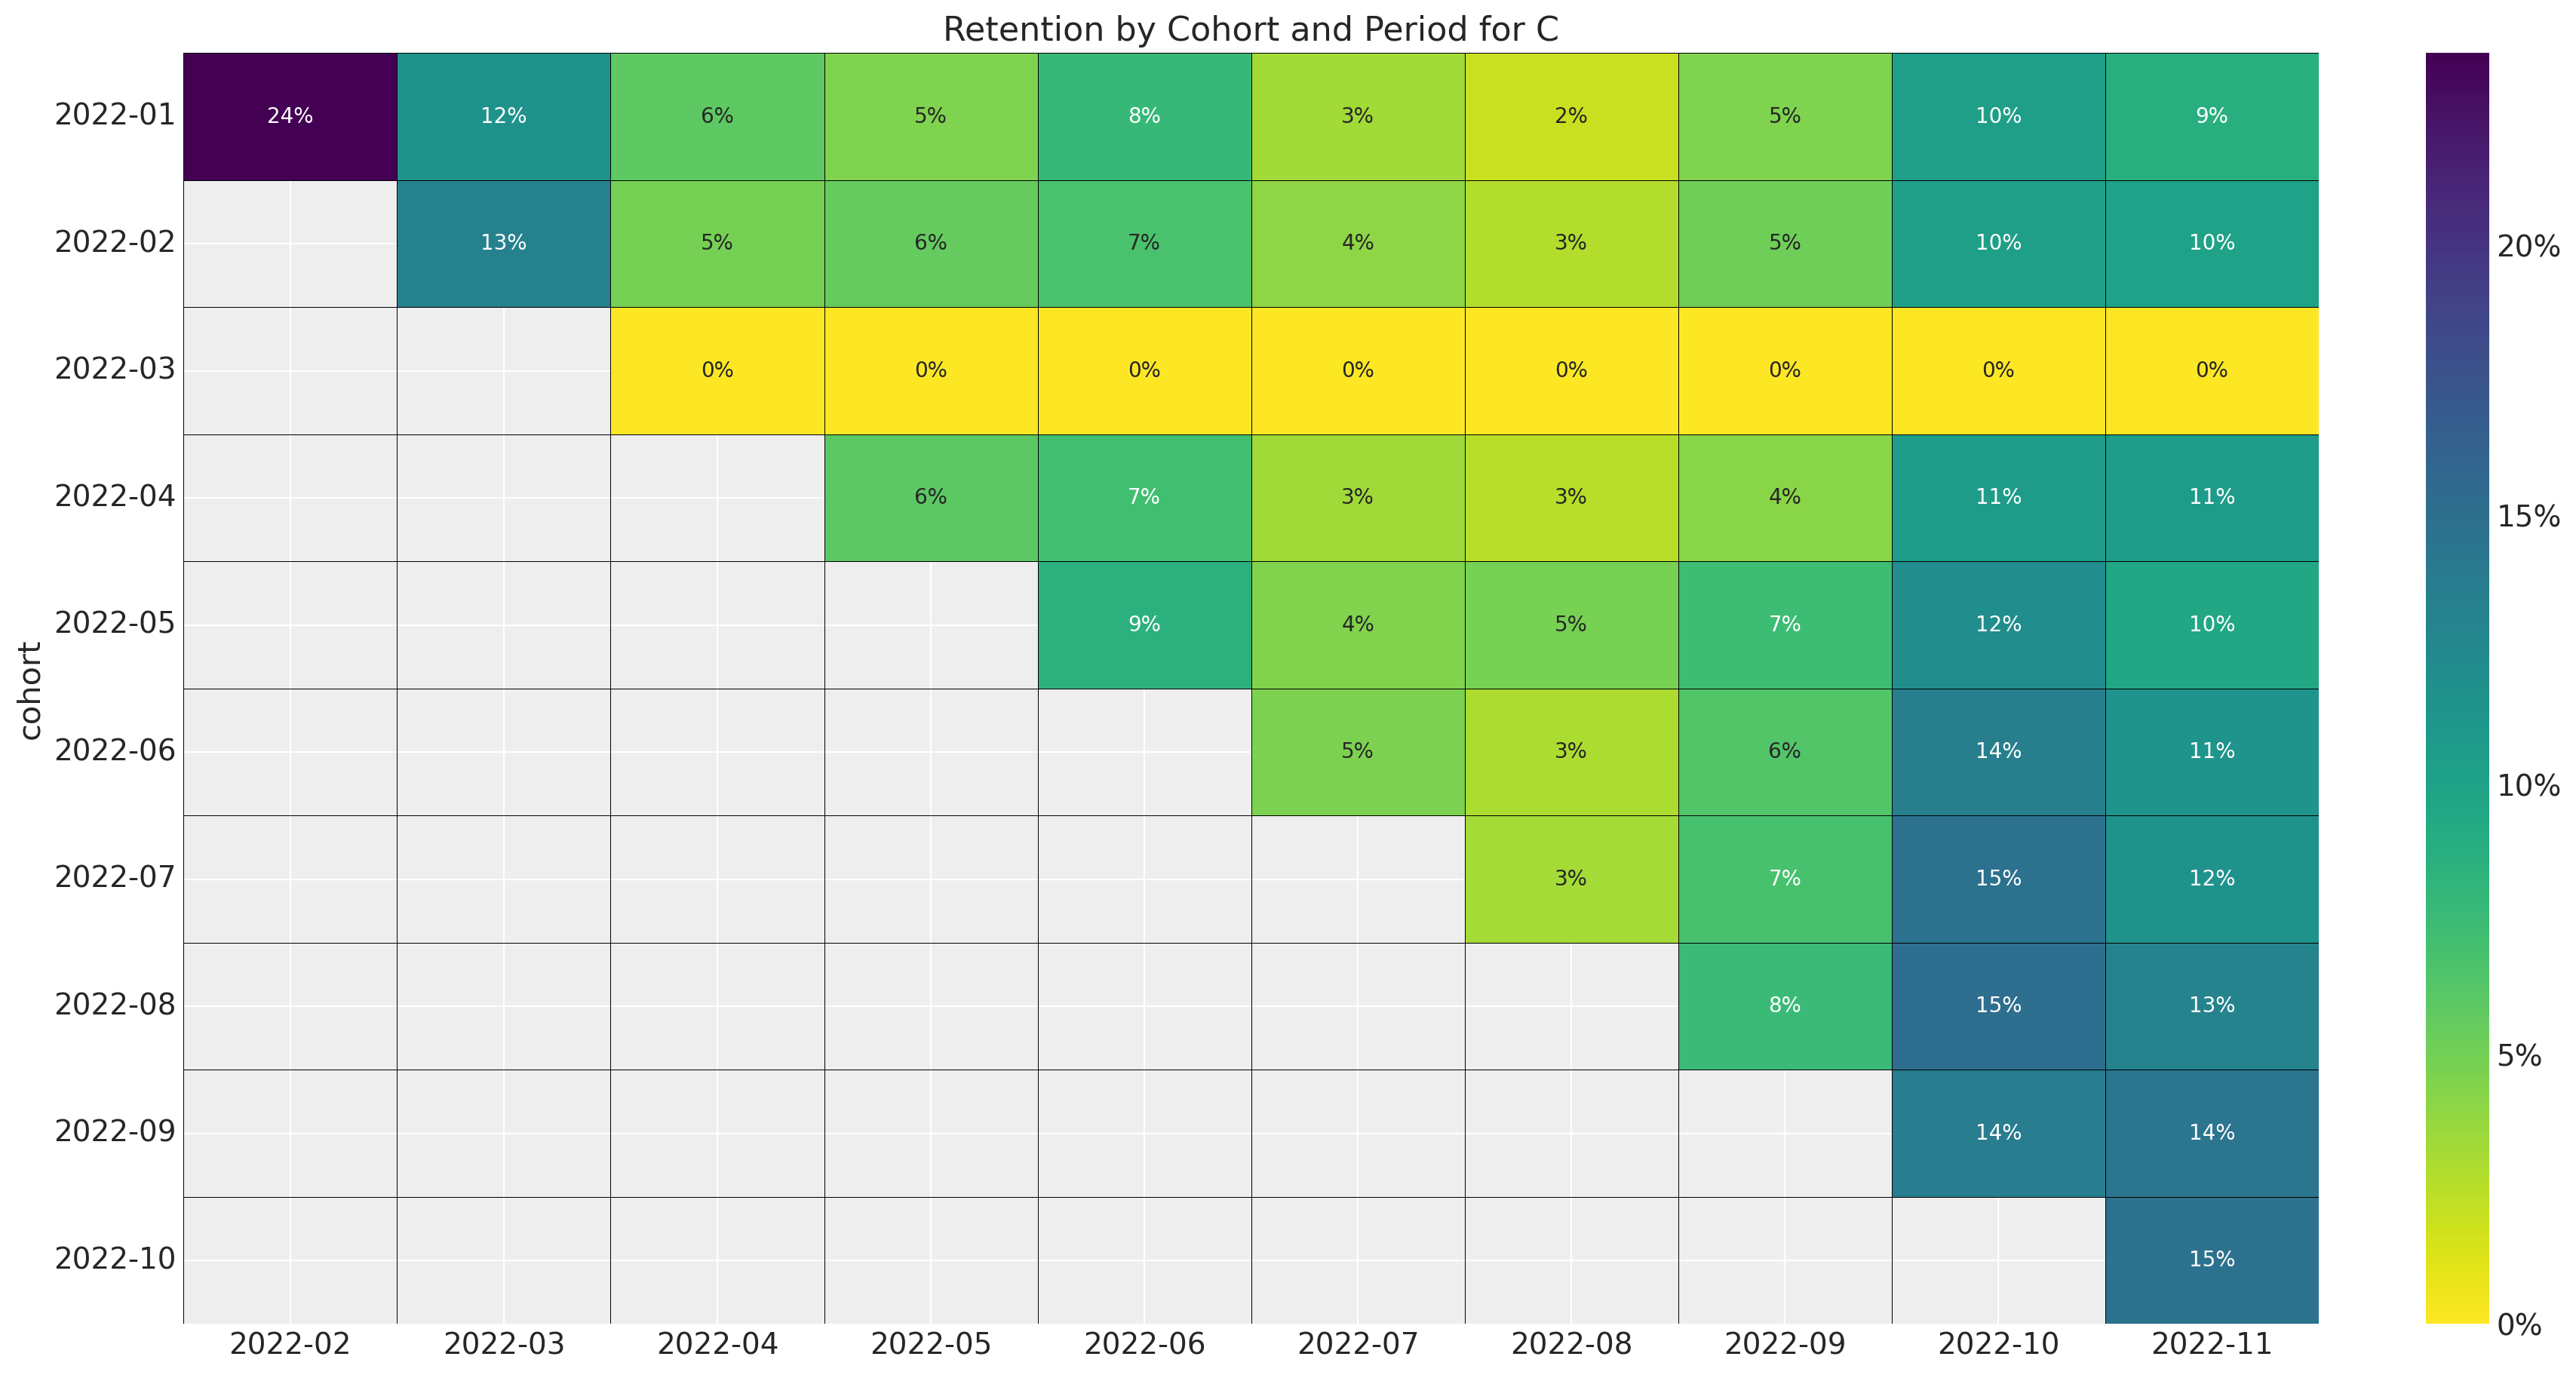

In [6]:
for market in markets:
    fig, ax = plt.subplots(figsize=(17, 9))

    (
        train_data_df.with_columns(
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
        )
        .filter(pl.col("cohort_age").ne(0) & pl.col("market").eq(market.name))
        .select(["cohort", "period", "retention"])
        .pivot(index="cohort", on="period", values="retention")
        .to_pandas()
        .set_index("cohort")
        .pipe(
            (sns.heatmap, "data"),
            cmap="viridis_r",
            linewidths=0.2,
            linecolor="black",
            annot=True,
            fmt="0.0%",
            cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:0.0%}")},
            ax=ax,
        )
    )

    [tick.set_rotation(0) for tick in ax.get_yticklabels()]

    ax.set_title(f"Retention by Cohort and Period for {market.name}")

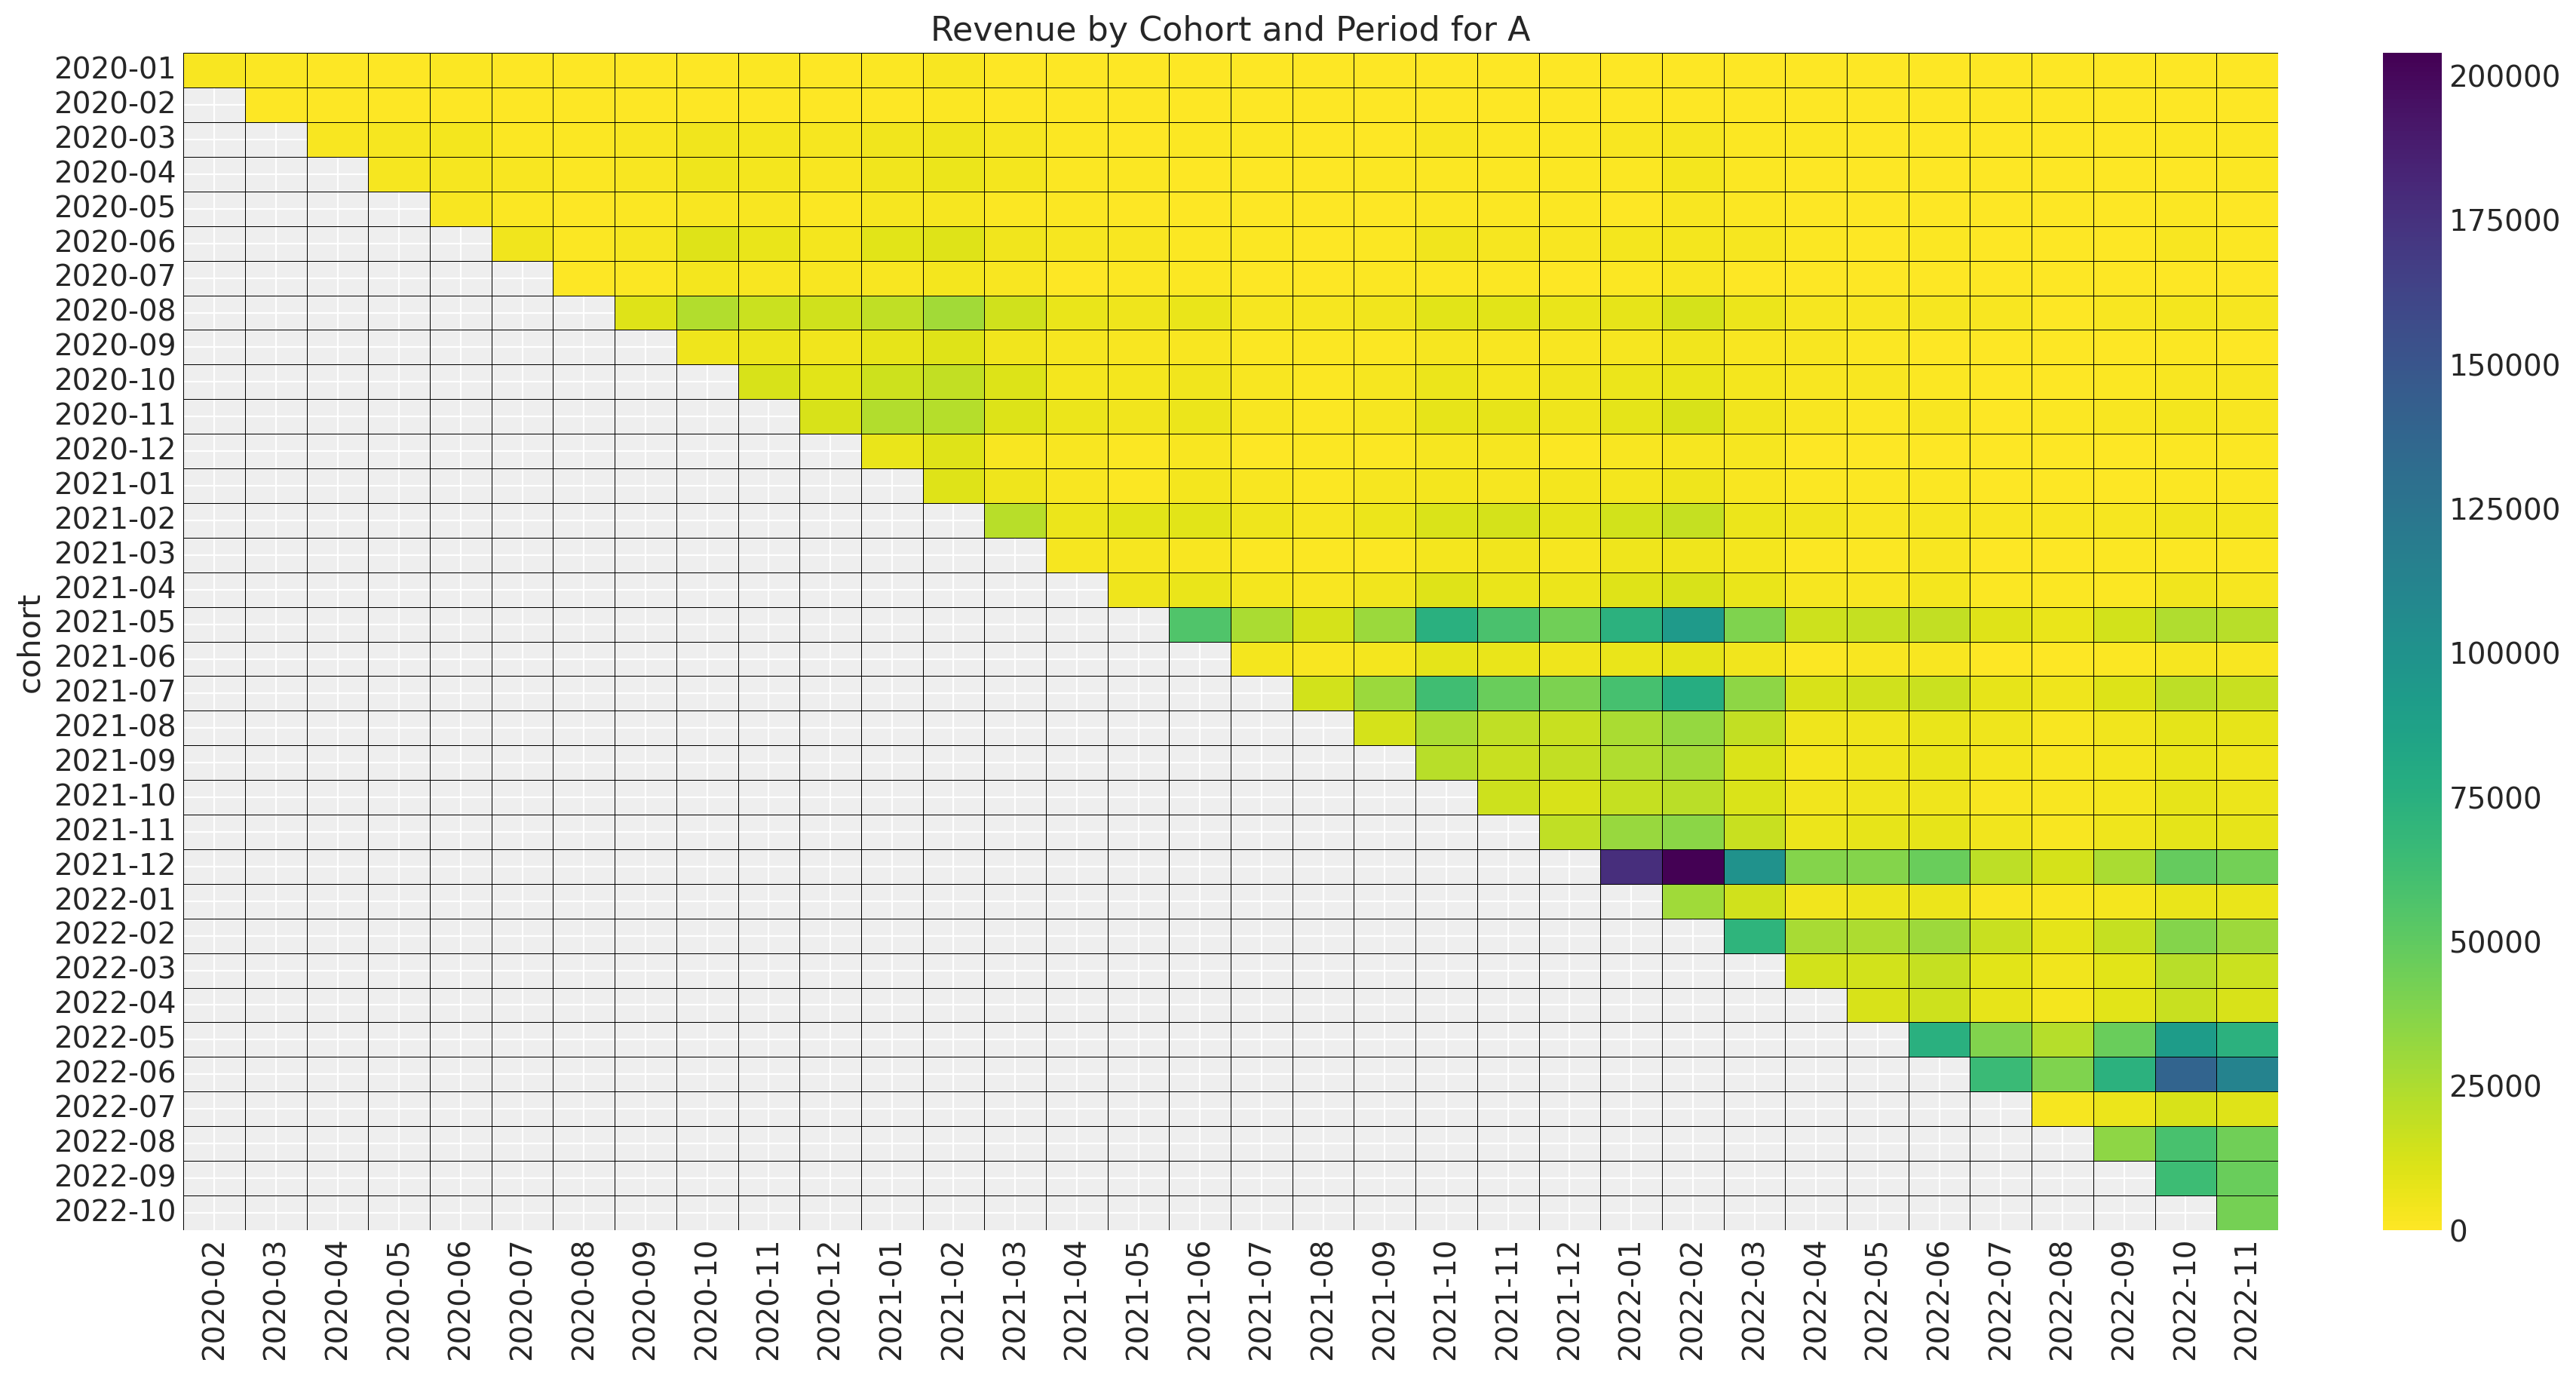

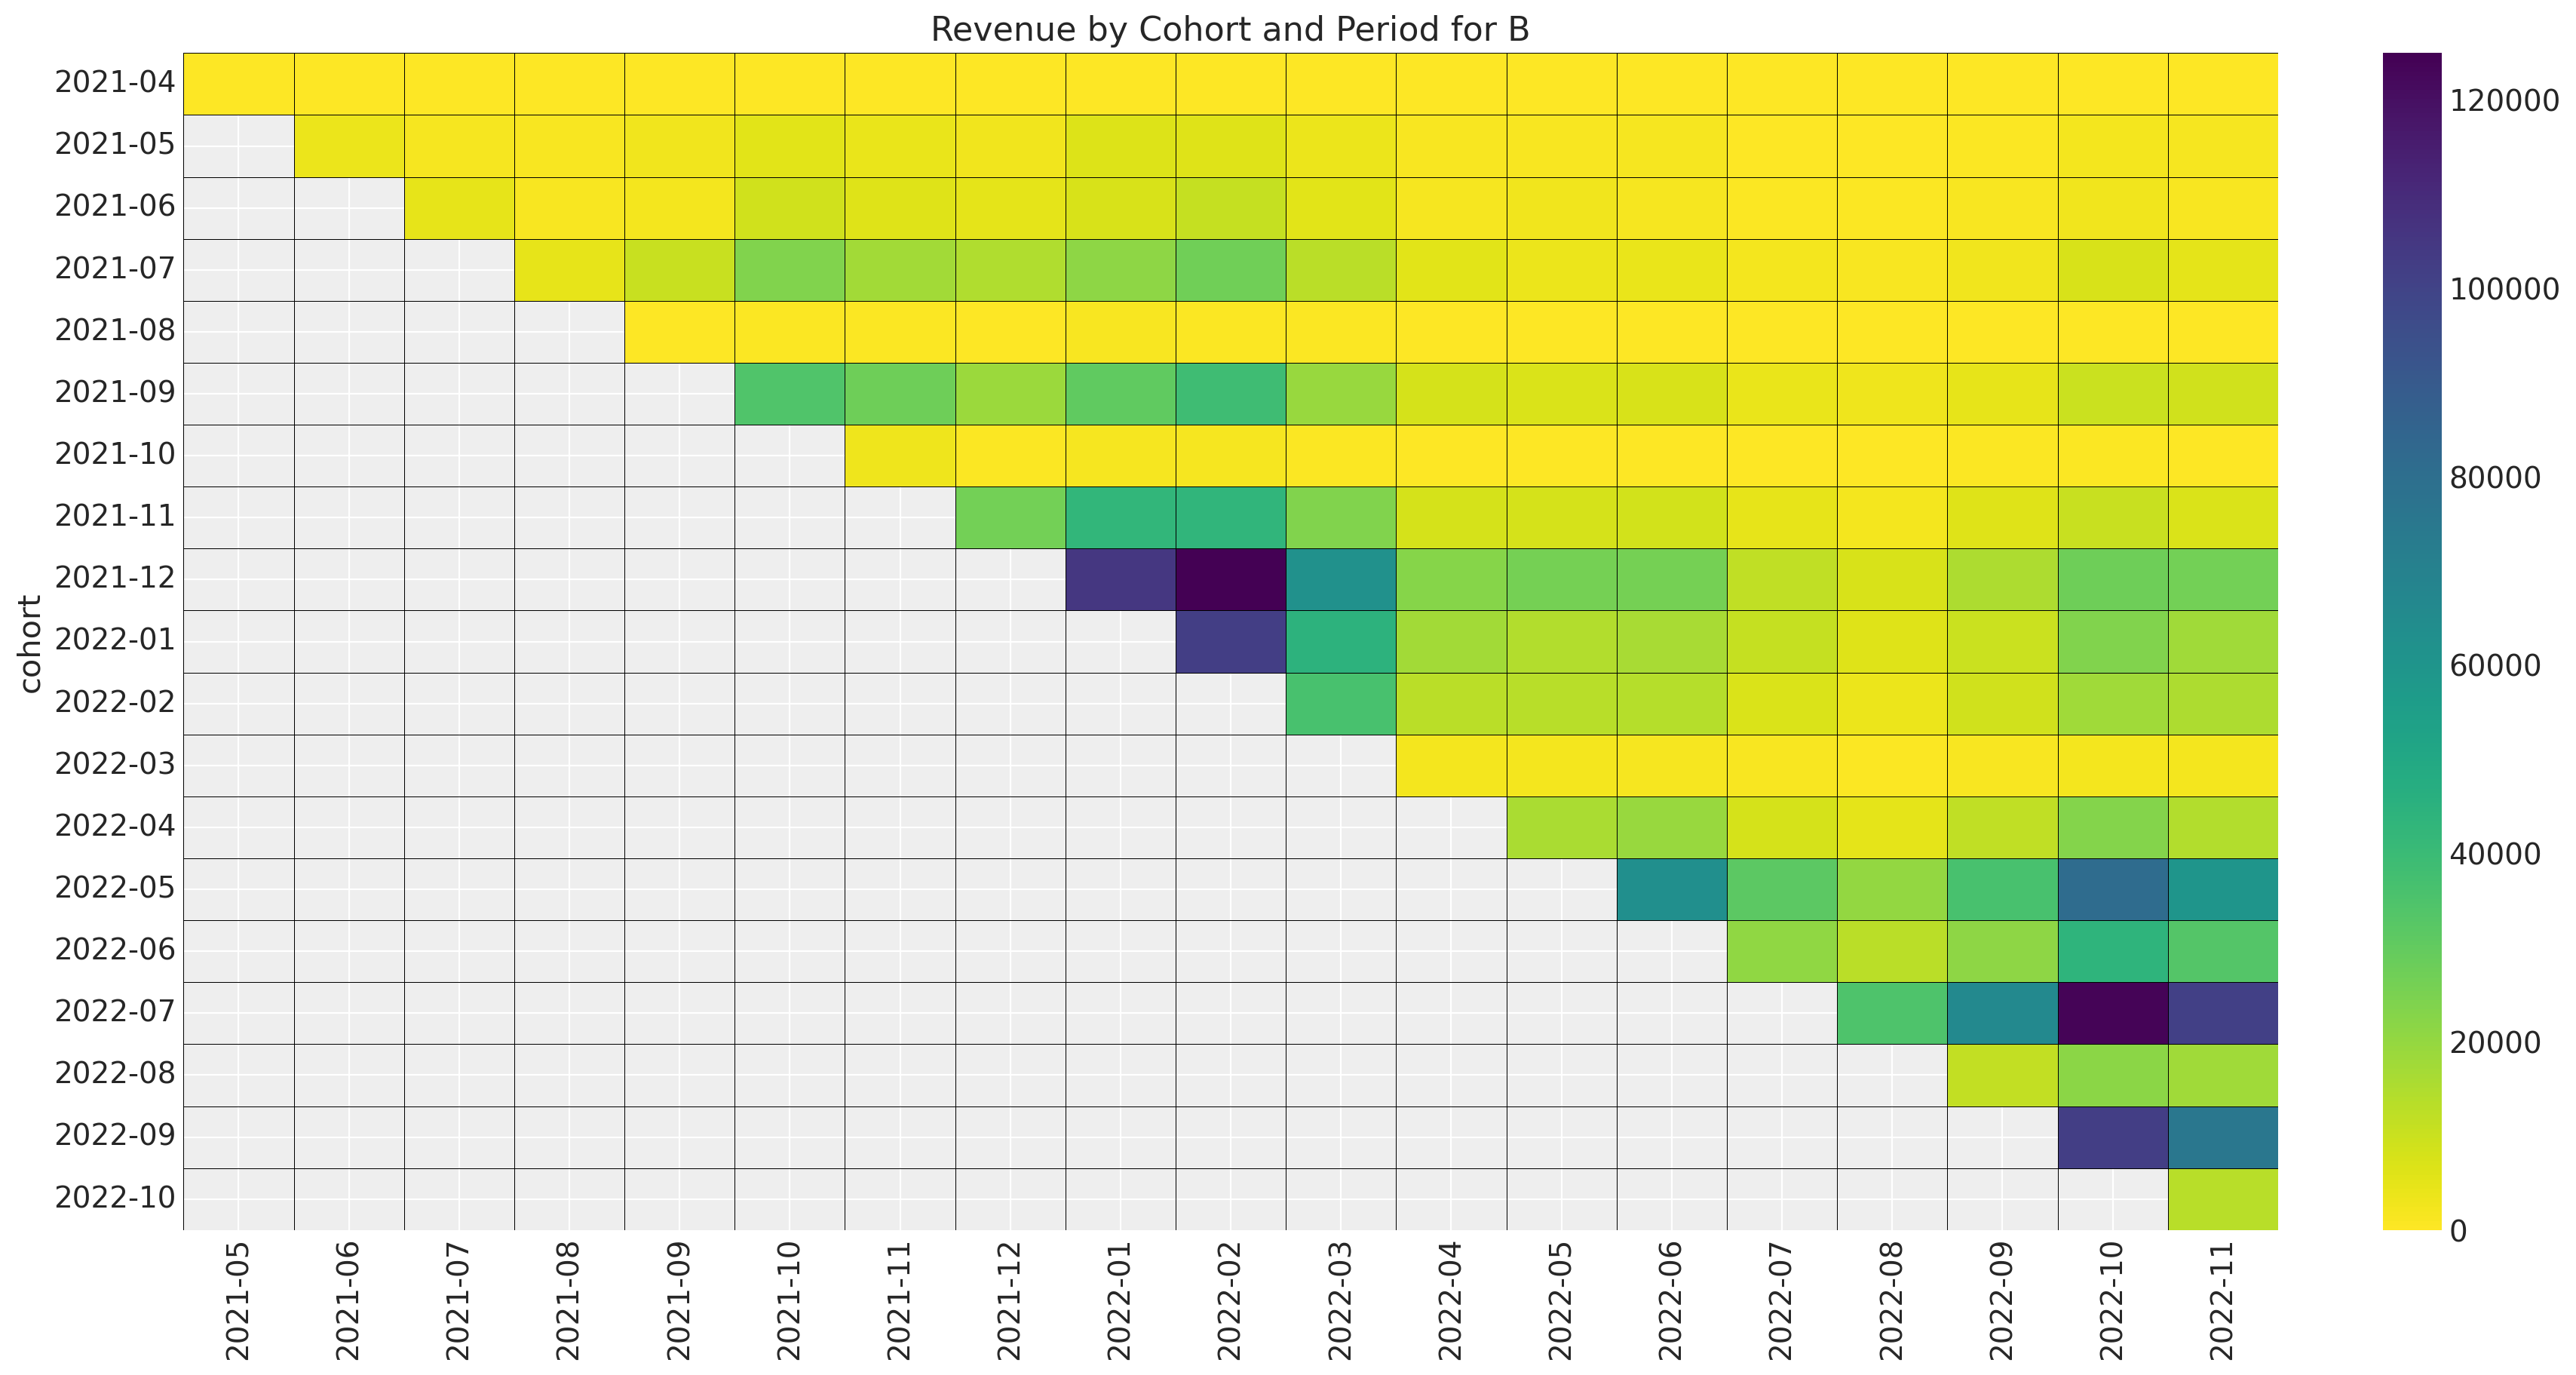

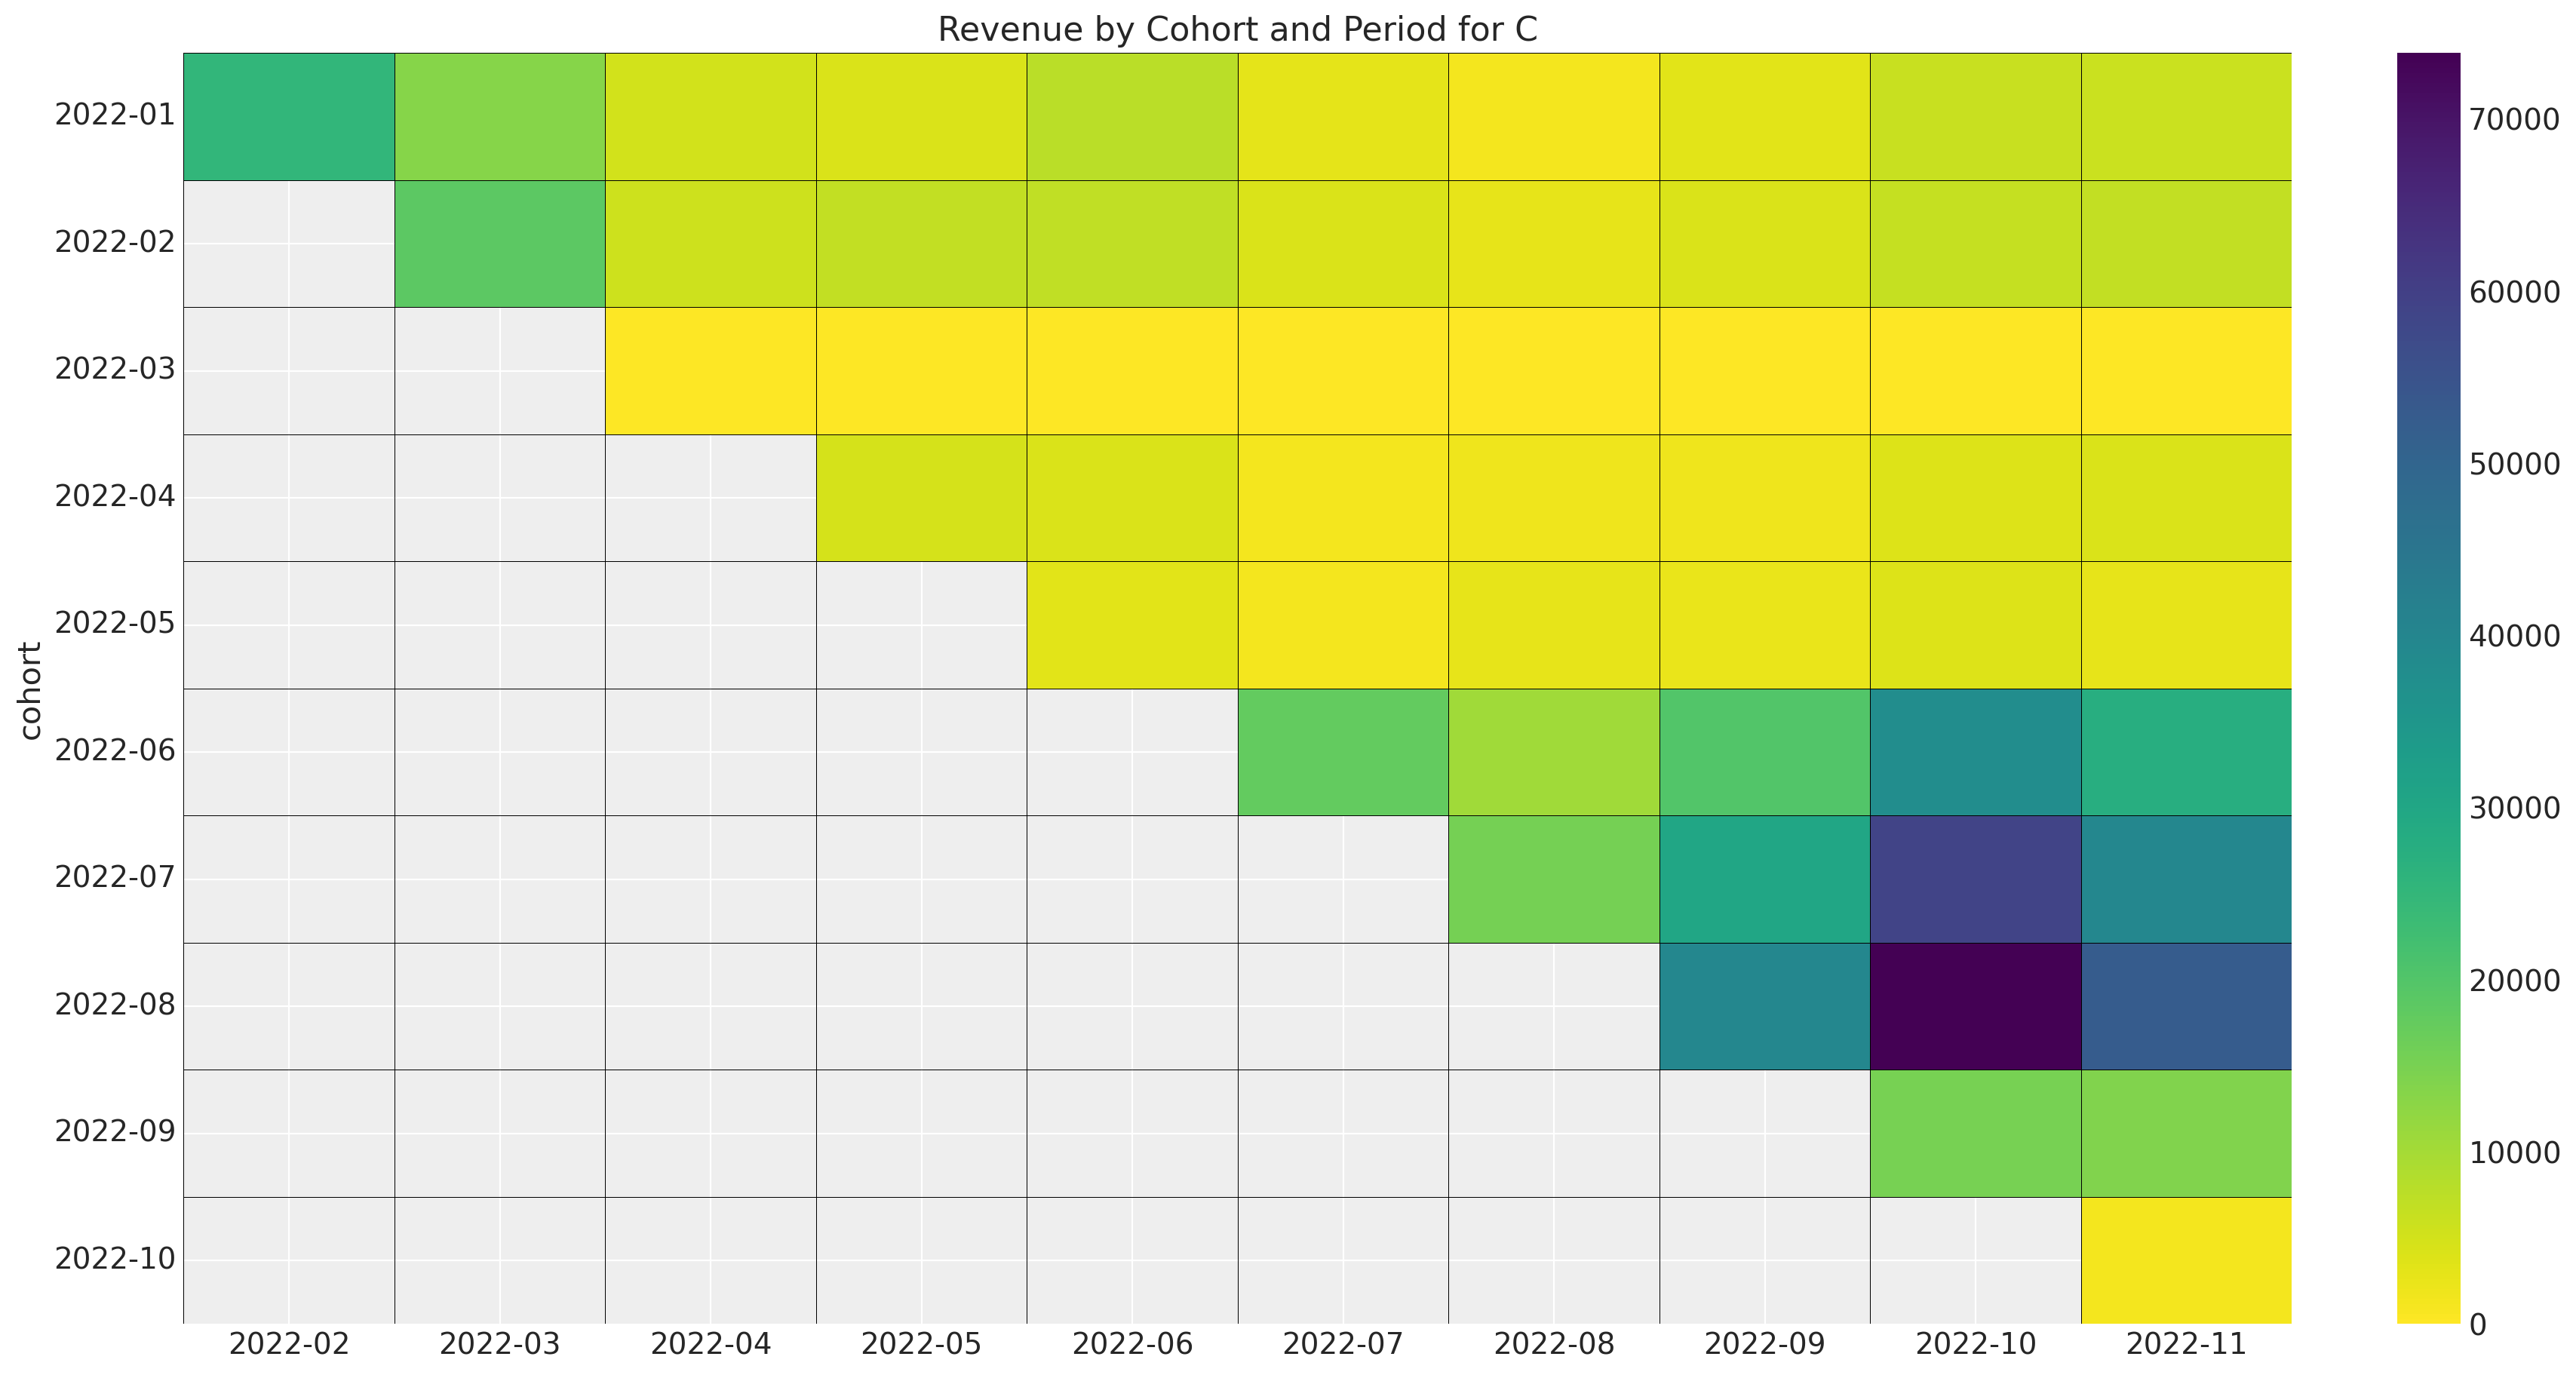

In [7]:
for market in markets:
    fig, ax = plt.subplots(figsize=(17, 9))

    (
        train_data_df.with_columns(
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
        )
        .filter(pl.col("cohort_age").ne(0) & pl.col("market").eq(market.name))
        .select(["cohort", "period", "revenue"])
        .pivot(index="cohort", on="period", values="revenue")
        .to_pandas()
        .set_index("cohort")
        .pipe(
            (sns.heatmap, "data"),
            cmap="viridis_r",
            linewidths=0.2,
            linecolor="black",
            cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y:0.0f}")},
            ax=ax,
        )
    )

    [tick.set_rotation(0) for tick in ax.get_yticklabels()]

    ax.set_title(f"Revenue by Cohort and Period for {market.name}")

In [ ]:
eps = np.finfo(float).eps

train_data_red_df = train_data_df.filter(pl.col("cohort_age").gt(0))
train_n_users = train_data_red_df["n_users"].to_jax()
train_n_active_users = train_data_red_df["n_active_users"].to_jax()
train_retention = train_data_red_df["retention"].to_jax()
train_retention_logit = logit(train_retention + eps)
train_revenue = train_data_red_df["revenue"].to_jax() + eps
train_revenue_per_user = train_revenue / (train_n_active_users + eps)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = [
    "age",
    "cohort_age",
    "cohort_month",
    "period_month",
    "market",
]
x_train = train_data_red_df[features]

train_age = train_data_red_df["age"].to_jax()
train_age_scaler = MaxAbsScaler()
train_age_scaled = jnp.array(
    train_age_scaler.fit_transform(np.array(train_age).reshape(-1, 1)).flatten()
)

train_cohort_age = train_data_red_df["cohort_age"].to_jax()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = jnp.array(
    train_cohort_age_scaler.fit_transform(
        np.array(train_cohort_age).reshape(-1, 1)
    ).flatten()
)

In [42]:
numerical_features = ["age", "cohort_age", "cohort_month", "period_month"]
categorical_features = ["market"]

numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_features_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_features_transformer, categorical_features),
    ]
).set_output(transform="polars")

preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)

x_train_preprocessed_array = x_train_preprocessed.to_jax()

In [43]:
class MLP(nnx.Module):
    def __init__(self, din, dout, hidden_layers, *, rngs, activation=jax.nn.relu):
        self.activation = activation
        self.layers = []
        layer_dims = [din, *hidden_layers, dout]
        for in_dim, out_dim in zip(layer_dims[:-1], layer_dims[1:], strict=False):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [77]:
rng_key, rng_subkey = random.split(rng_key)

retention_nnx_module = MLP(
    din=x_train_preprocessed_array.shape[1],
    dout=1,
    hidden_layers=[4, 1],
    rngs=nnx.Rngs(rng_subkey),
    activation=jax.nn.sigmoid,
)

In [81]:
def model(
    x: Float[Array, "obs features"],
    age: Float[Array, " obs"],
    cohort_age: Float[Array, " obs"],
    n_users: Int[Array, " obs"],
) -> None:
    retention_nn = nnx_module("retention_nn", retention_nnx_module)

    retention = numpyro.deterministic("retention", retention_nn(x).squeeze(-1))

    intercept = numpyro.sample("intercept", dist.Normal(loc=0, scale=1))
    b_age = numpyro.sample("b_age", dist.Normal(loc=0, scale=1))
    b_cohort_age = numpyro.sample("b_cohort_age", dist.Normal(loc=0, scale=1))
    b_interaction = numpyro.sample("b_interaction", dist.Normal(loc=0, scale=1))

    lam_raw = numpyro.deterministic(
        "lam_log",
        intercept
        + b_age * age
        + b_cohort_age * cohort_age
        + b_interaction * age * cohort_age,
    )

    lam = numpyro.deterministic("lam", jax.nn.softplus(lam_raw))

    with numpyro.plate("data", len(x)):
        n_active_users_estimated = numpyro.sample(
            "n_active_users_estimated",
            dist.Binomial(total_count=n_users, probs=retention),
        )

        numpyro.deterministic("retention_estimated", n_active_users_estimated / n_users)

        numpyro.sample(
            "revenue_estimated",
            dist.Gamma(concentration=n_active_users_estimated + eps, rate=lam),
        )

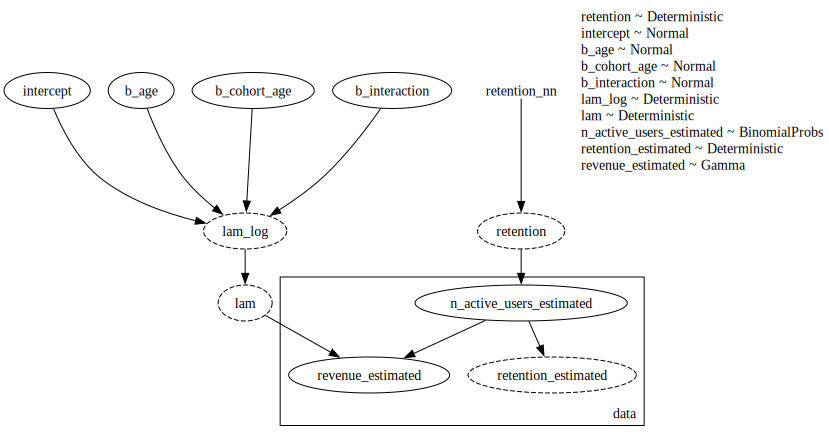

In [82]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "x": x_train_preprocessed_array,
        "age": train_age_scaled,
        "cohort_age": train_cohort_age_scaled,
        "n_users": train_n_users,
    },
    render_distributions=True,
    render_params=True,
)